# Линейная регрессия на реальных данных (продолжение)

Полезные ссылки: 
- [Пайплайны в sklearn (документация)](https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html)
- [Пайплайны в sklearn (youtube)](https://www.youtube.com/watch?v=jzKSAeJpC6s)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

## Подготовка данных

И снова здравствуйте, Малые Кармакулы

In [40]:
df = pd.read_csv('EDA_demo_data/karmakuly_processed.csv', parse_dates=['Date'], index_col='Date')
df.head()

#df = df['2015':]

print ('df shape with nans: ', df.shape)
df = df.drop (['tg', 'td', 'psl'], axis=1)
df = df.dropna()
print ('df shape without nans: ', df.shape)
df.head()



df shape with nans:  (163632, 12)
df shape without nans:  (128354, 9)


,tcc,lcc,wdir,wvel,wgust,prec,ta,rh,ps
Date,,,,,,,,,
1976-11-30 18:00:00,3.0,0.0,110.0,27.0,30.0,0.0,-22.6,88.0,1003.7
1976-11-30 21:00:00,2.0,0.0,120.0,25.0,28.0,0.0,-22.8,85.0,1003.4
1976-12-01 00:00:00,0.0,0.0,110.0,23.0,28.0,0.0,-22.9,85.0,1003.6
1976-12-01 03:00:00,0.0,0.0,100.0,26.0,30.0,0.0,-23.3,86.0,1002.8
1976-12-01 06:00:00,3.0,0.0,110.0,27.0,31.0,0.0,-23.3,85.0,1002.3


## Порождение дополнительных признаков

<Axes: title={'center': 'day_pos (diurnal cycle)'}, xlabel='Date'>

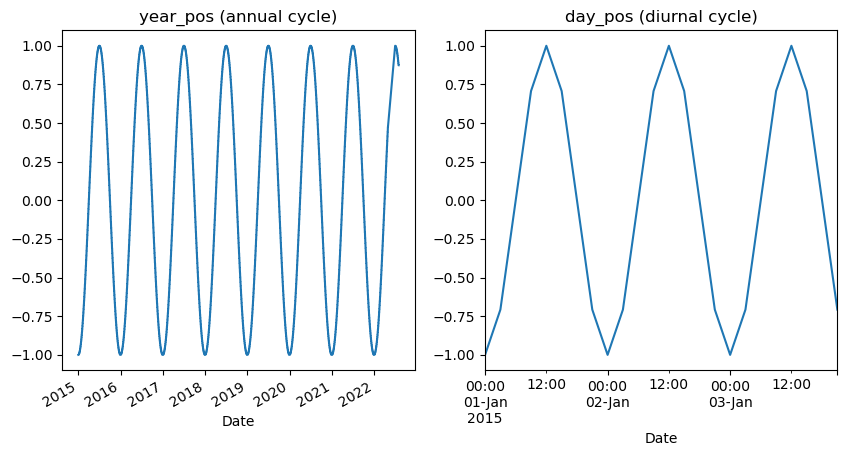

In [41]:
df['year_pos'] = np.cos (np.pi + 2 * np.pi * df.index.dayofyear/365)
df['day_pos']  = np.cos (np.pi + 2 * np.pi * df.index.hour/24)

fig, ax = plt.subplots (1,2, figsize=(10,5))

df['2015':]['year_pos'].plot(ax = ax[0], title='year_pos (annual cycle)')
df['2015-01-01':'2015-01-03']['day_pos'].plot(ax = ax[1], title='day_pos (diurnal cycle)')

## Обучение и проверка модели 

Для начала посмотрим на оценки, если обучать и проверять модель на одних и тех же данных

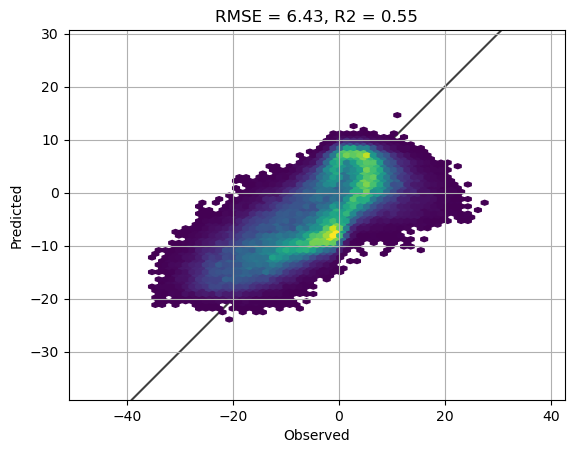

In [62]:
def evaluate_model (model, X, y):
       y_pred = model.predict(X)

       plt.figure()

       plt.hexbin (y, y_pred, mincnt=1, gridsize=50)

       plt.axis('equal')
       ax = plt.gca()
       lims = [
              np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
              np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
              ]
       plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
       plt.xlim(lims)
       plt.ylim(lims)
       plt.grid()
       plt.xlabel('Observed')
       plt.ylabel('Predicted')

       r = np.corrcoef(y_pred, y)[0,1]
       r2 = r2_score(y, y_pred)
       mse = mean_squared_error(y, y_pred)

       plt.title ('RMSE = %.2f, R2 = %.2f'%(np.sqrt (mse), r2))

target_var = 'ta'

y = df[target_var]
X = df.drop(target_var, axis=1)

model = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
                #('regressor', CatBoostRegressor(silent=True)) 
                ])

model.fit(X, y)
evaluate_model (model, X, y)



## Разделение на тестовую и тренировочную выборки 

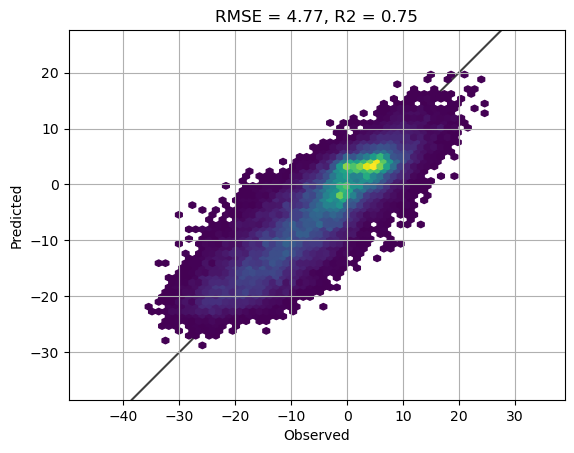

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,  shuffle=False) 

model.fit(X_train, y_train)
evaluate_model (model, X_test, y_test)

## Анализ коэффициентов модели (для линейной регрессии)

In [61]:
coefs = pd.DataFrame(model['regressor'].coef_, X.columns, columns=['coef']) 
display(coefs)

,coef
tcc,0.039911
lcc,0.000073
wdir,-0.241840
wvel,6.532113
prec,0.091092
ta,0.189510
rh,-0.208449
ps,-0.212517
year_pos,-0.201242
day_pos,-0.032376
